### PART 1 // Imports and first global data visualization

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import plotly.express as px
import plotly.graph_objects as go

In [29]:
data_src = pd.read_csv('src/Speed Dating Data.csv',encoding = "ISO-8859-1")

In [30]:
data_src

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,22.0,1,44,2,21,22,14,10.0,5,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0


The dataset has 8378 rows, Ok... that's small...
but there are 195 columns! Ok, let's see the documentation!...
In the documentation, it is not easy to understand all the mechanisms of this dataset.
A row is an encounter between a woman and a man, from the point of view of one person.
So, in another part of the dataset, we have a row for the same encounter (the opposite sex) but with more information (favorite activities, career, survey responses, etc...) for that opposite sex person. It's like a "semi-mirror" structure.

Let's look the value counts of types of columns...

In [31]:
data_src.dtypes.value_counts()

float64    174
int64       13
object       8
dtype: int64

OK, what are the 8 strings types ?... 

In [32]:
[col for col in data_src.columns if data_src[col].dtypes=='object']

['field',
 'undergra',
 'mn_sat',
 'tuition',
 'from',
 'zipcode',
 'income',
 'career']

To see that, we can open the file on Excel... And while we check theses columns... surprise ! There is a problem of line offset at rows 4650 to 4663 and 6908 to 6922. Exemple :

<img src='./images_report/pb_decalage_lignes.png'>

These problems are solved with Excel because it's very easier...

Let's re-import the file :

In [33]:
data_src = pd.read_csv('src/Speed Dating Data_clean.csv',encoding = "ISO-8859-1")

After understanding all the parameters, we try to see if we can't remove some of them, perhaps...
Can we visualize it ? 

In [34]:
fig = px.bar(data_src.isnull().sum(),title='Missing_values')
fig.show()

We have a lot of missing values for 'expnum', 'undergra', etc... and also all the last survey (the third) and especially the question 7...

One of the goals of this study will be to see if we can use these surveys, so be careful ! So, we will not delete everything, but only the columns that have more than 5500 empty cells (this is also because question 7 of the surveys is an "introspective" question, redundant with the other questions, and will be difficult to exploit)

In [35]:
data_src.drop(columns=[col for col in data_src.isnull().sum().index if data_src.isnull().sum()[col]>=5500],inplace=True)

Now, let's see, on a "rather crude" approach, where we can look for possible correlations...
Ok, let's look at a big correlation map!... (Don't be afraid)

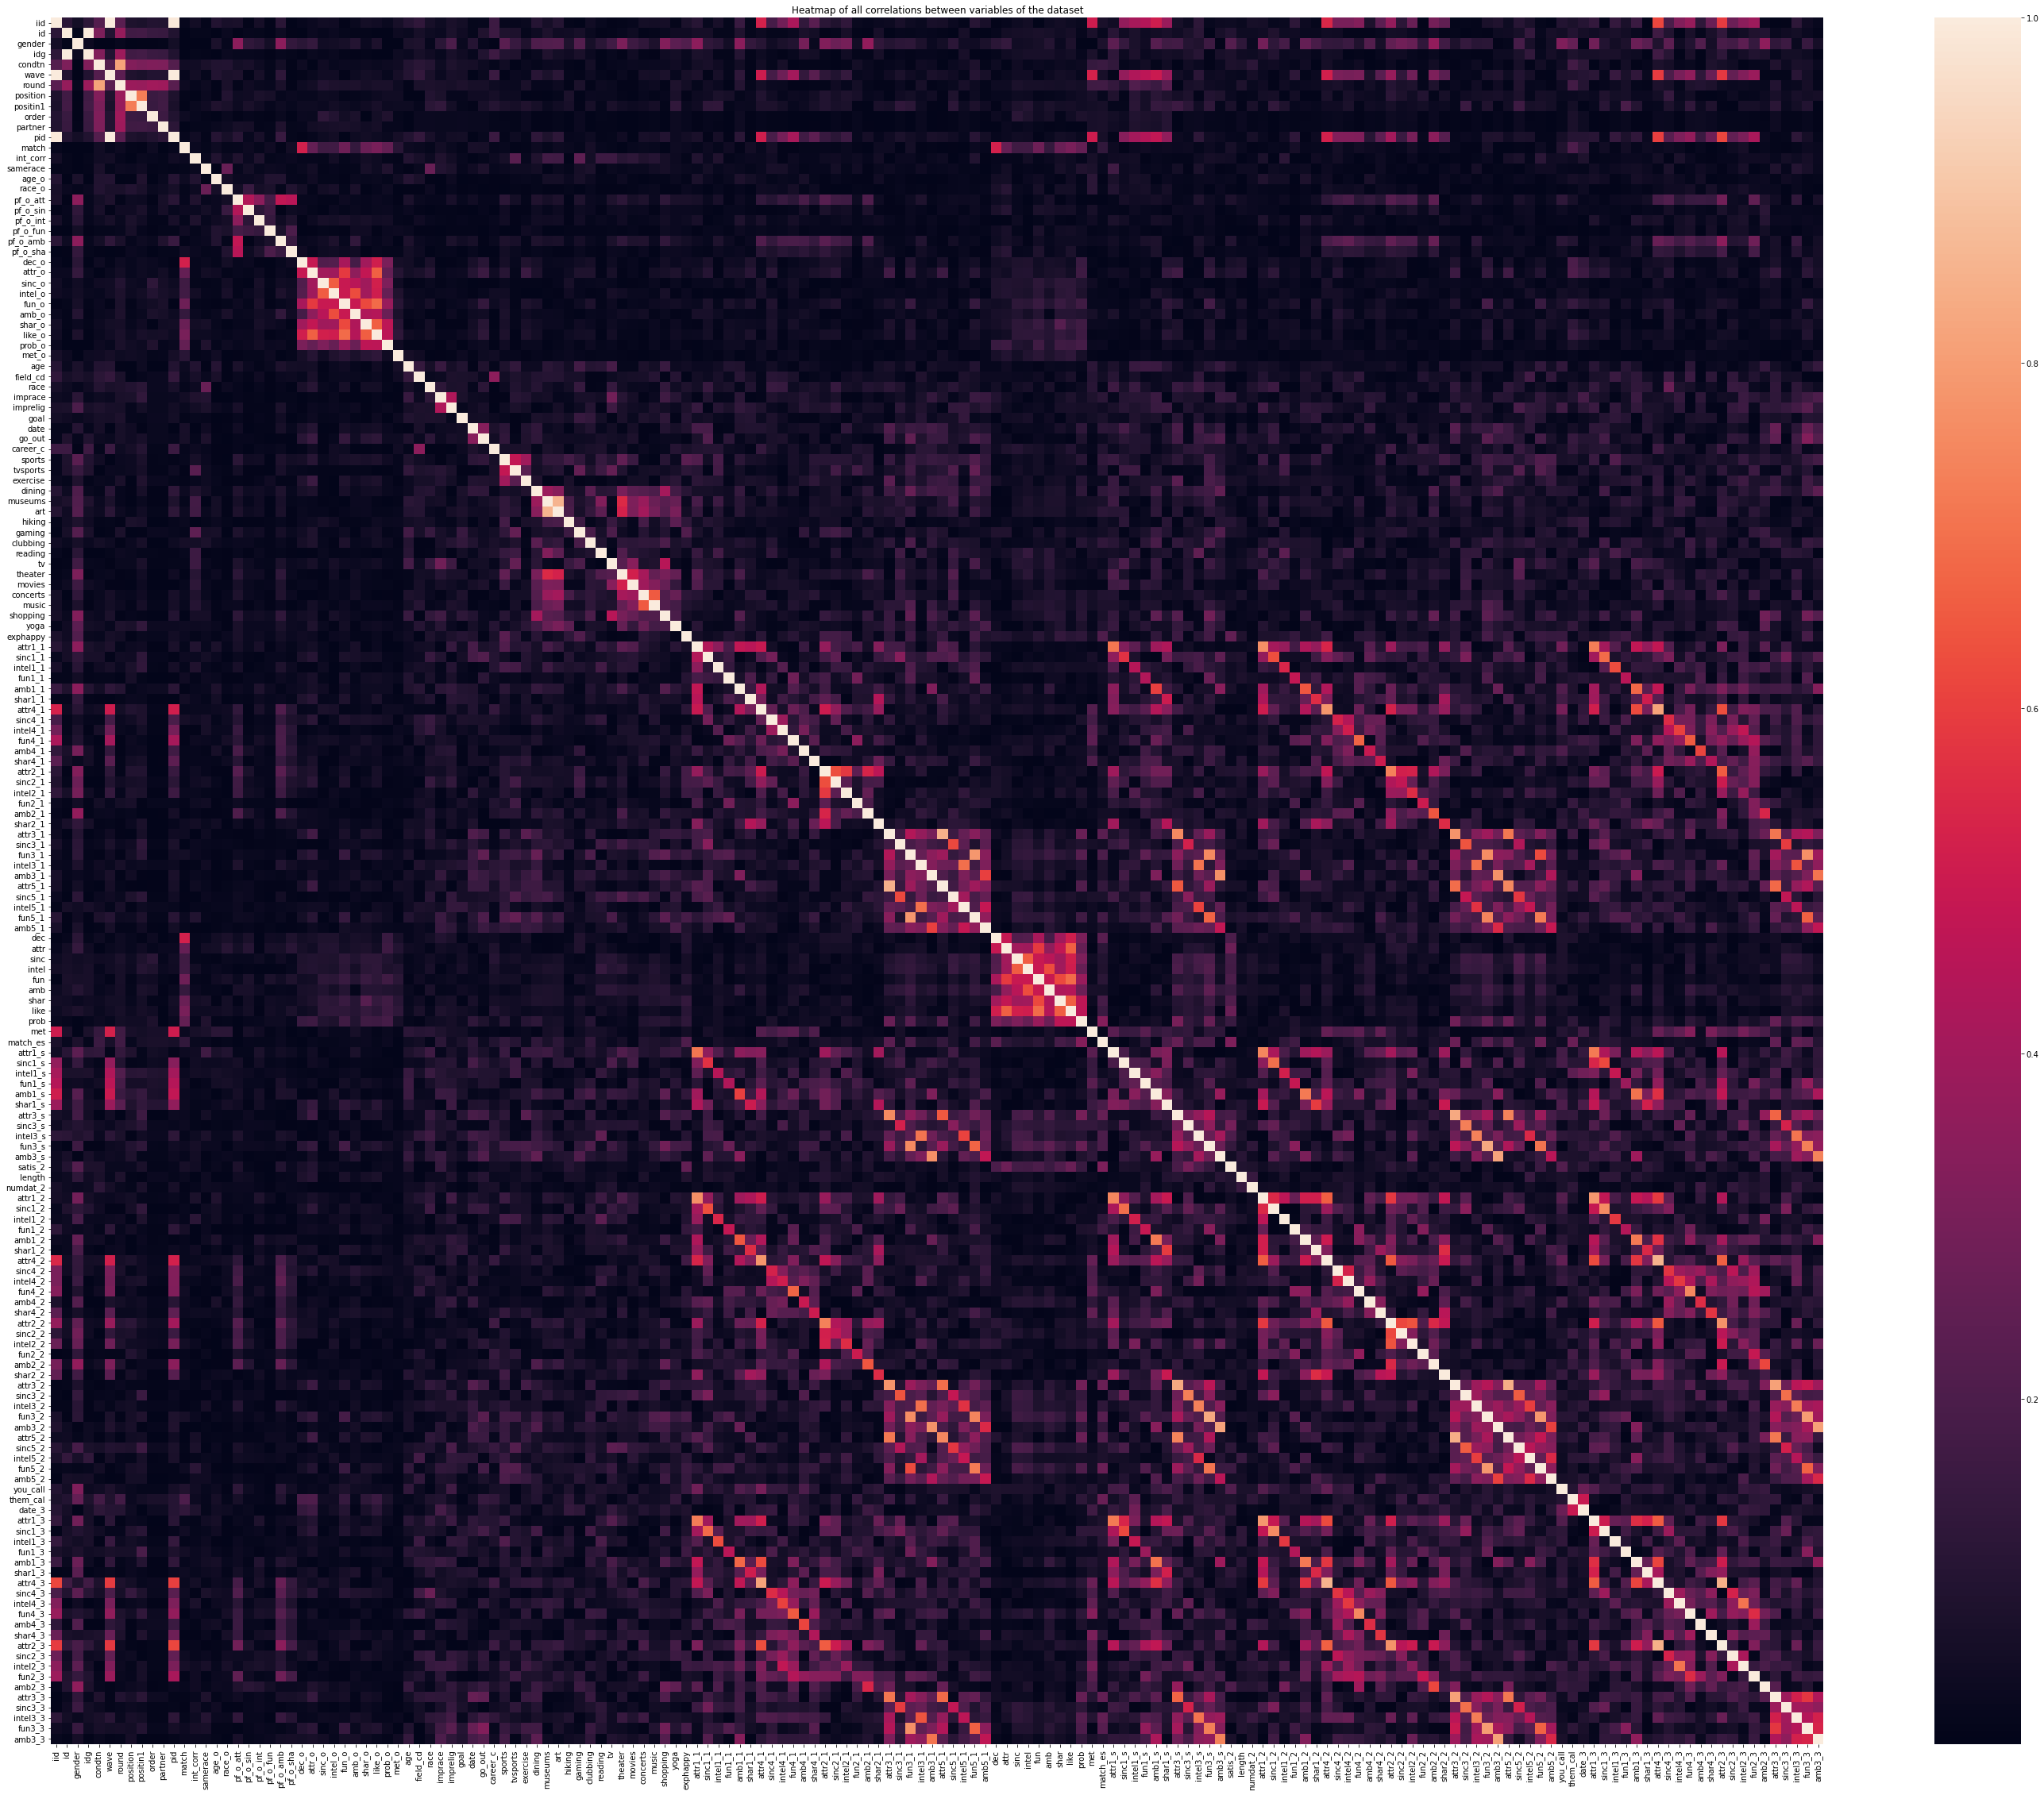

In [36]:
data_corr = data_src.corr()
plt.figure(figsize=(50,40))
plt.title("Heatmap of all correlations between variables of the dataset")
sns.heatmap(abs(data_corr))
plt.show()

It's a big, big, big ... heatmap, very beautiful !... But how can we exploit it?
It's not really necessary, because in other parts of this EDA study, we will only observe the correlation with the variables "dec", "dec_o", "match" and "date_3"...

So, this is just to take some information:
It's not very easy to see the information... (you can open it on your favorite image processing software, the heatmap is saved in 'images_report') and we can notice that :
- you can see big isolated correlations... For example: "art" and "museums", "music" and "concerts"... ok that makes sense... Someone who likes one can like the other...
- we have "mechanical correlations" between "wave", "round", "pid", "dec" and "match"... Ok, that makes sense too, it's just a process question.
- we have many visible heat squares of 6x6 pixels or 10x10 pixels... These are our surveys! Survey 1 responses will be correlated to survey 2 responses, etc... A person does not seem to give very different answers from one survey to another for the same question. We will confirm this later, when we want to exploit the different surveys ....


### PART 2 / The speed dating night : how do men and women make decisions ? what could constitute a "match" ? 

For this part, we just look at the first part of the experimentation, the speed dating night, from the first survey to the "match". With all the families of parameters presented (activities, affinities, psychological states of mind, racial origin...), which are the most important?

Here we have a small toolbox...
Just two functions that will be used below:
- to make a kind of "podium" of variables correlated to a parameterized variable, by adjusting a certain threshold (correlation_top function)
- to display each variable of this same "podium" with 3 distinct graphs (histogram of the variable, boxplot and logistic regression with the studied parameter) (function display_distrib_all_corr_top)

In [37]:
def correlation_top(data,var_test,not_selectionned,percent_corr):   
    data_corr = data.corr()
    return data_corr.loc[[term for term in data_corr
                        .index if term not in not_selectionned and abs(data_corr.loc[term,var_test])>=percent_corr],var_test].sort_values(ascending=False)

def display_distrib_all_corr_top(data,top_corr_serie,var_test):
    for charac in top_corr_serie.index:
        fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,3))
        sns.histplot(data=data,x=charac,ax=ax1)
        sns.boxplot(data=data,x=charac,ax=ax2)
        sns.regplot(data=data,x=charac,y=var_test,logistic=True,ax=ax3)
        plt.suptitle("Variable tested : {}     | Data number : {} - Coefficient correlation (Pearson) : {}".format(charac,data[charac].count(),round(top_corr_serie[charac],2)))
    

At each moment of our study, we will try to find results for women, and after that, for men... (gallantry obliges, of course!).
We are interested in the possible difference of the parameters highlighted between the two.
So, let's try to apply our correlation_top function on all women, with the correlation parameter "dec" (decision).
"dec" does not mean "match". For a "match" to occur, both must make a positive decision. ("match"=1 if and only if "dec"=1 and "dec_o"=1).

In the function we defined above, we have the option to not display a list of selected parameters in the "podium" result. It's a back and forth job to add a "not_selected" variable to this list, if the variable is displayed and we don't actually want it... Here we remove variables like 'dec' (correlation = 1!), 'match', or 'date_3' and 'them_cal' which are "mechanical" (process dependent) and/or anachronistic...
Another back and forth work: try different correlation thresholds (here: 0.15 ) to have a good "podium" with the best positive and negative correlation.

In [38]:
data_women = data_src.loc[data_src['gender']==0,:]
not_selectionned = ['dec','match','them_cal','date_3']
top_dec_women = correlation_top(data_women,'dec',not_selectionned,0.15)
top_dec_women

like        0.477620
attr        0.444979
fun         0.416553
shar        0.413190
prob        0.285092
match_es    0.242444
intel       0.232939
sinc        0.222265
satis_2     0.183773
amb         0.175386
prob_o      0.166153
Name: dec, dtype: float64

OK, for women, it seems that the family of notes ("attr", "fun", "shar"...) on men is the most important, well before other families of variables like activities... This seems logical, of course !...
But maybe we can order these variables. What are the most important characteristics of a man to a woman?
It looks like:
1) In the first place: Attractive, Fun and Hobbies/Activities to share...
2) In second place (less important): Intelligence, sincerity and ambition...

In our "podium", we also have some parameters :
- "like" . This is the best !... OK, to take the decision to "mate" a person, it is better to "like" this person... (maybe we should put this variable in the "unselected" list ?)
- "match_es". This is the expectation of the number of "matches". If there is a real correlation, it means that a woman, perhaps, makes her "match" decision with a man because she knows she will be successful tonight with all her partners... but it may be the other way around: because she makes a lot of positive match decisions, she has a good idea of her "match" expectation.
- Prob" and "prob_o"... idem, maybe believing that the man will choose the woman will influence the woman's decision, but maybe it's the opposite! More simply, it may be a representation of the reciprocal "feeling" : "ok, I chose him because we felt together that we could agree"...
- satis_2" : the global satisfaction of the evening. Idem, are we satisfied because we made a lot of positive decisions, or the opposite?...

With our second function, we can check all these correlations. It is simply an additional possible quality indicator for each of them:

WARNING : this function can be slow... Indeed, it computes a logistic regression (and not a linear regression) because our common parameter studied, "dec", is a binary parameter. So, you can visualize it... but if you want to run it... maybe, go have a coffee?

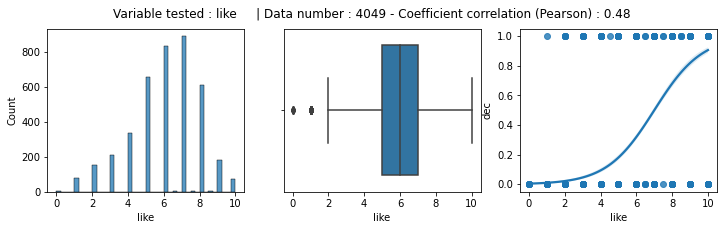

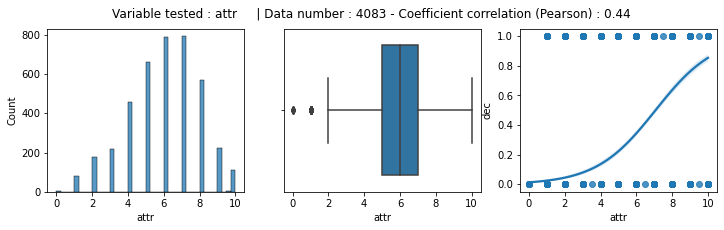

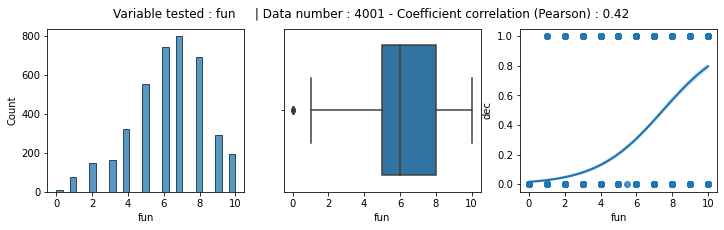

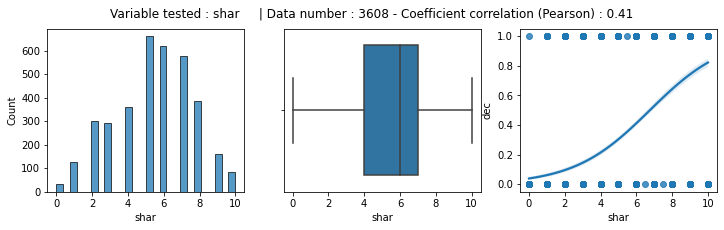

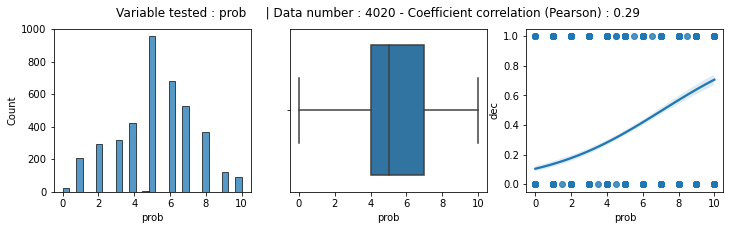

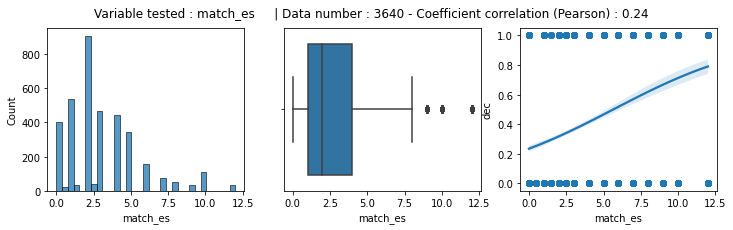

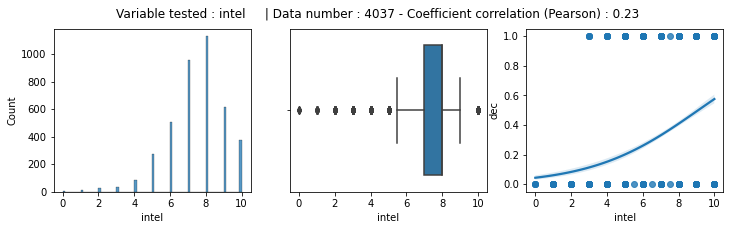

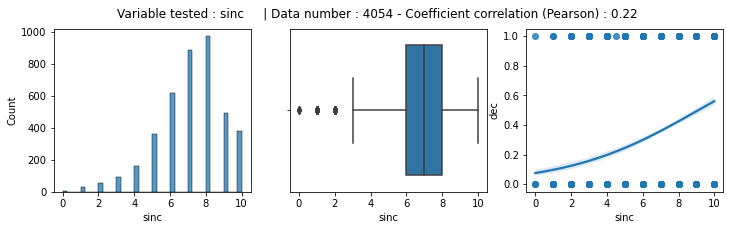

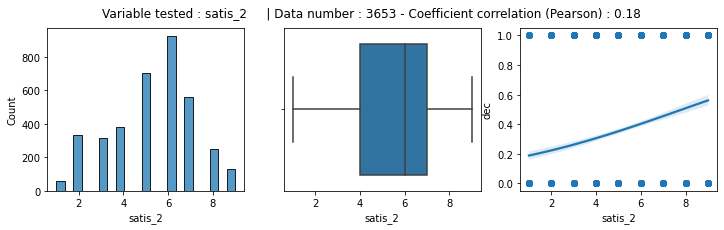

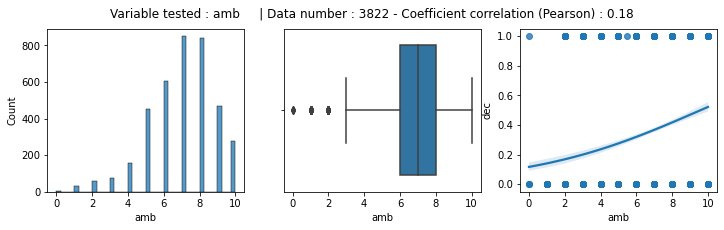

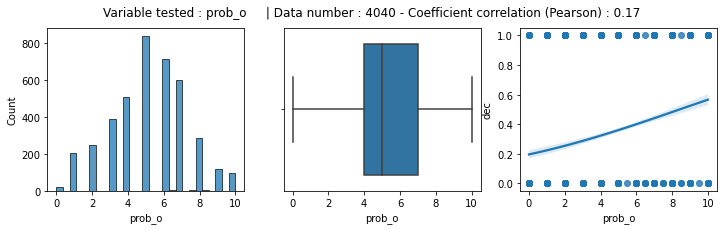

In [39]:
display_distrib_all_corr_top(data_women,top_dec_women,'dec')

The interest is to visualize a context favorable to a "bad" correlation:
- an abnormal distribution of the variable (not very uniform, for example... or very tight)
- presence of many outliers
- insufficient data
- a low Pearson correlation coefficient
...
Each item in this list may not be a problem, but the combination of several problems may lead us to reconsider the quality of the correlation.
For example, here, sincerity, ambition and intelligence, already at the bottom of our "podium", seem to be even lower... "Match_es" too.


Finally, putting aside the "like", we should retain the parameters: Attraction, Fun and Shared Hobbies.
And maybe, in a second time, "prob" and "satis_2"... which should be interesting parameters to study, in a next other experimentation...

Now, the same thing for men :

In [40]:
data_men=data_src.loc[data_src['gender']==1,:]
not_selectionned = ['dec','match','them_cal','date_3']
top_dec_men = correlation_top(data_men,'dec',not_selectionned,0.15)
top_dec_men

like        0.544448
attr        0.515497
fun         0.407360
shar        0.387368
prob        0.340901
amb         0.219542
intel       0.216818
match_es    0.205258
sinc        0.190859
satis_2     0.174032
Name: dec, dtype: float64

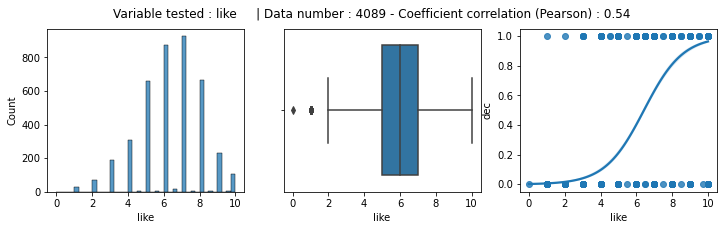

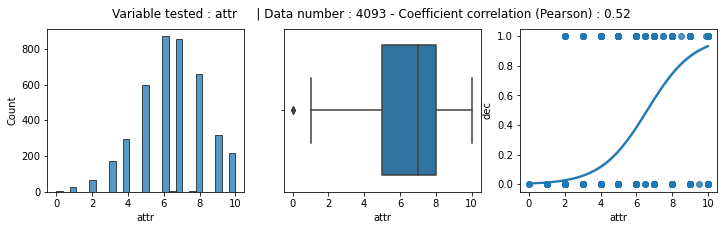

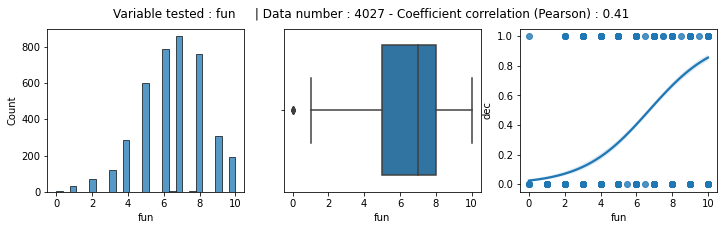

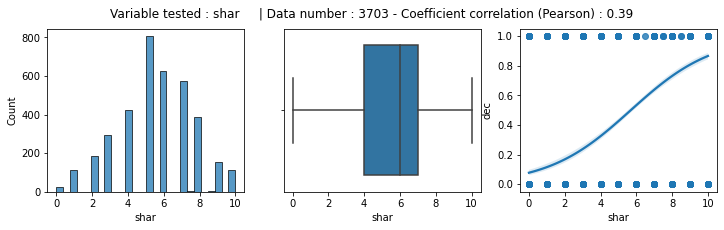

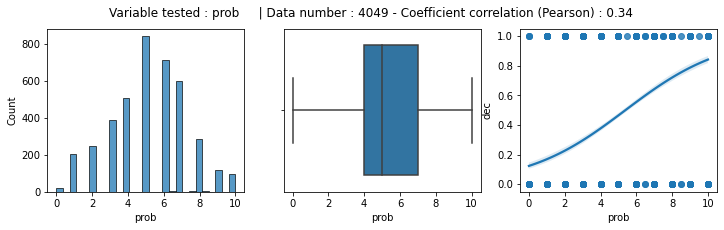

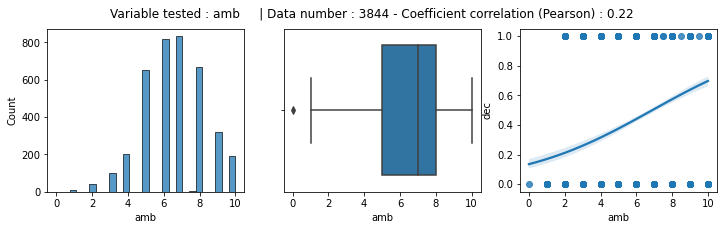

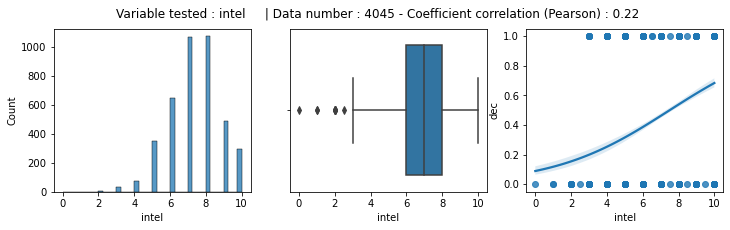

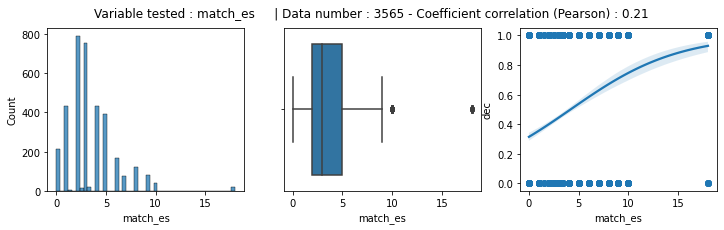

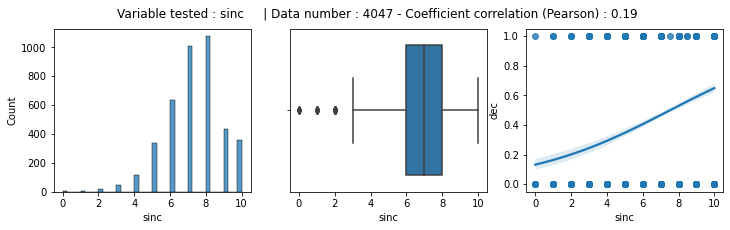

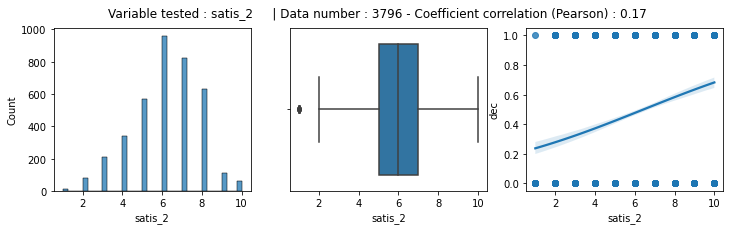

In [41]:
display_distrib_all_corr_top(data_men,top_dec_men,'dec')

For men, we find the same first trio: Attractive, Fun and Shared Interests/Hobbies...
(Attractiveness is even more correlated for men: 0.51 against 0.44 for women! )
And, in a second time, we find the same variables: the "second trio" (Intelligence, Sincerity and Ambition), the expectation of "match", the global satisfaction (again there seems to be a bad correlation) and the "prob"...

OK, we have identified the best parameters to produce a "match", and it is the same for men and women... and that is not very surprising...
But, if we focus on these variables (attr/sinc/etc...), are these variables important in a second time: when the speed dating evening is over and we have to see if the "match" will become a "second date"? This is the subject of the third part...

### PART 3 // How a "match" can become a second date ?

A "match" between a woman and a man, during the speed dating evening, is not everything... it is just a sharing of phone numbers. During the 3/4 weeks following this evening, men and women will have appointments or not, and, in the experiment, only will answer new surveys... 

To begin with, we need to check whether the scoring variables (attr/sinc/etc...) during speed dating will be important for getting a second date.
This is not very easy because "date_3" is the binary answer to the question: "Did you get a date with any of your partners?" and not: "Did you get a date with THIS partner?" (the partner in the row in the dataset)... So, we can simply measure the probability of having a second appointment after 3/4 weeks on a personal basis.

(We could make a large joined table between the dataset and the same dataset a second time, and select the people with "match"=1 to do that... We tried it! But it was not very efficient, unfortunately... for the same reasons as the method below. We keep here the solution which has the simplest form)

So, let's study what kind of variable is correlated with "date_3"...
Will the rating variables be as important as in the second part (the speed dating party)?...


We could begin by find all the top parameters correlated with "date_3"... and see if rathings variables are always in best positions (it is wath we'll do later) but before that, it's an occasion to try an other tool in our toolbox :

In [42]:
def rep_by_step(list_tested):

    data_match = data_src.loc[data_src['match']==1,:]

    data_with_date = data_match.loc[data_match['date_3']==1,:]

    data_melted_base = data_src.melt(id_vars=['gender'],value_vars=list_tested,value_name='Charac').groupby(['gender','variable']).mean().reset_index()
    data_melted_base['Cat']='Base population - Nb data : {}'.format(min(data_src[list_tested].count()))

    data_melted_with_match = data_match.melt(id_vars=['gender'],value_vars=list_tested,value_name='Charac').groupby(['gender','variable']).mean().reset_index()
    data_melted_with_match['Cat']='with match - Nb data : {}'.format(min(data_match[list_tested].count()))

    data_melted_with_date = data_with_date.melt(id_vars=['gender'],value_vars=list_tested,value_name='Charac').groupby(['gender','variable']).mean().reset_index()
    data_melted_with_date['Cat']='With second date 3/4 weeks - Nb data : {}'.format(min(data_with_date[list_tested].count()))

    data_for_viz = pd.concat([data_melted_base,data_melted_with_match,data_melted_with_date]).reset_index()
    data_for_viz['gender']=data_for_viz['gender'].map({0:'Women',1:'Men'})
    fig = px.line(data_for_viz,
            x='variable',
            y='Charac',
            color='gender',
            facet_col='Cat',
            color_discrete_sequence=['#eebbaa','#4488dd'],
            title="Rates repartition (Selection Effect)"
            )
    fig.show()

The rep_by_step function is a visualization function that will display the evolution of the mean of the distribution of a set of variables (the input list) during the experiment:
- for the first time, in the whole population (with or without "match")
- then, in the population of women and men who had a "match" during the speed dating evening
- and finally, in the population that had a "second date" (date_3).
This allows us to check if there is some kind of "natural selection" or "selection effect" during these three stages.

(The function is a little complex because we have to use "melt" and "groupby" methods for each of the "conditionnal" dataset )

Let's try this with our "rathings variables"...

In [43]:
list_tested=['attr','sinc','intel','fun','amb','shar','like']
rep_by_step(list_tested)

Here we can observe, in another way, the impact of the "rating variables" on the "match" variable... People (men and women) who have a "match" have distributed higher scores for all characteristics. The change is most dramatic for the characteristics Attraction, Pleasure, Shared Hobbies, and others... the best variables we have identified so far.

But between step 2 ("match") and step 3 ("date_3"), it seems that there is no difference... 
Perhaps ratings variables will play less in the final result ?...

And be careful, look at the number of data:
there is a strong reduction of the population!... So it will be difficult not to misinterpret the process. (a variation between step 1 and step 2, or step 2 and step3, will be perhaps just an "expression of the variance" to a smaller sample each time.)

Now, we try also to use the same method than part 2 with women who have a "match", and study if she have a "second date", with the function "correlation_top" (our podium of correlation) :

In [44]:
data_women_with_match = data_women.loc[data_women['match']==1,:]
not_selectionned = ['date_3','them_cal']
top_dec_women_with_match = correlation_top(data_women_with_match,'date_3',not_selectionned,0.2)
top_dec_women_with_match

intel1_s    0.281337
hiking      0.267089
shar1_3     0.255144
age         0.251929
clubbing    0.236266
intel2_2    0.204942
satis_2     0.203723
sinc5_1    -0.212878
imprelig   -0.221695
amb3_s     -0.231850
fun3_3     -0.231962
fun3_s     -0.232330
sinc1_s    -0.237886
intel3_s   -0.240003
sinc3_s    -0.254137
fun5_2     -0.268032
intel5_2   -0.302085
amb5_1     -0.330441
amb5_2     -0.388358
Name: date_3, dtype: float64

OK, it is less obvious than in part 2, at the speed dating party...
But there are a lot of variables of the same correlation importance that are different in nature: activities, survey response, importance of religion...

A very important note: the whole family of "rathings variables" (attr/sinc/etc...) is gone!
This is a confirmation of the above with the visualization of the selection "step by step".
Two interpretations:
- (The mathematical explanation) As it was said, "date_3" measures the success of a person on all possible second dates... So, all his/her evaluations on all his/her partners are considered in the same way... This may end up like a soup of ratings: impossible to separate the "good" ratings (for "good dates") from the others.
- (the sociological explanation) Perhaps the ratings don't play too much after the speed dating evening because persons have get to know each other during the 3/4 weeks (by phone, before a possible second date)

Let's see that with men :

In [45]:
data_men_with_match = data_men.loc[data_men['match']==1,:]
not_selectionned = ['date_3','them_cal','you_call']
top_dec_men_with_match = correlation_top(data_men_with_match,'date_3',not_selectionned,0.2)
top_dec_men_with_match

fun4_1      0.366890
amb2_1      0.351253
intel2_3    0.301327
sinc4_2     0.281944
intel1_s    0.275250
amb2_3      0.268660
intel4_3    0.263527
sinc5_2     0.252278
fun4_3      0.241554
intel4_1    0.238080
fun1_s      0.235437
shar1_1    -0.209508
clubbing   -0.212482
amb1_3     -0.213231
met        -0.218140
attr3_s    -0.218161
shar1_2    -0.239083
career_c   -0.241752
concerts   -0.249135
imprace    -0.267317
shar2_2    -0.292145
gaming     -0.320386
shar2_1    -0.320624
Name: date_3, dtype: float64

It's the same kind of results... It's difficult to disentangle all of it.

So we will organise the variables in three categories wich will studied alternatly.

#### 3.1 Impact of activities on a second date

In [46]:
activies=['sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']


For the activities list, we can use our function correlation_top with a list of not_selectionned but alos with a tested list : the list of activities...

In [47]:
data_women_with_match_activities = data_women_with_match.loc[:,[term for term in data_women_with_match if term in activies or term =='date_3']]
not_selectionned = ['date_3']
top_dec_women_with_match_activities = correlation_top(data_women_with_match_activities,'date_3',not_selectionned,0.1)
top_dec_women_with_match_activities

hiking      0.267089
clubbing    0.236266
yoga        0.148552
exercise    0.101881
theater    -0.155348
concerts   -0.176123
shopping   -0.178434
tv         -0.180073
music      -0.190224
Name: date_3, dtype: float64

Good job! Maybe for a woman, hiking, clubbing, yoga and exercise are good characteristics to reinforce a "match" (have a "date_3"...) and the others don't help.

But the correlations are low, and we have to check it with a visualization :

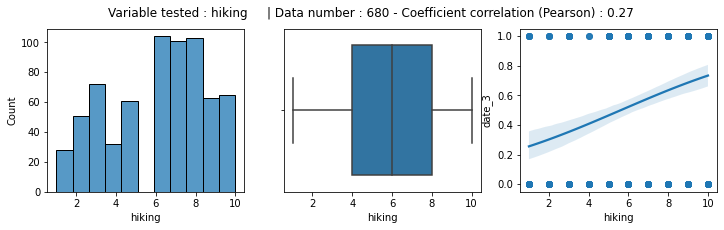

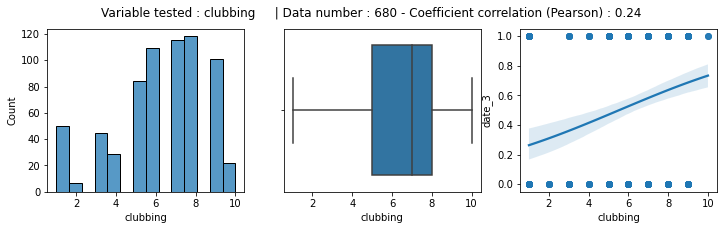

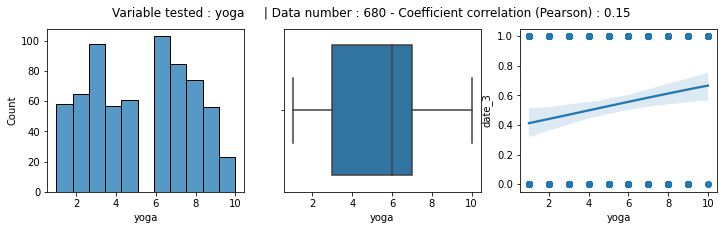

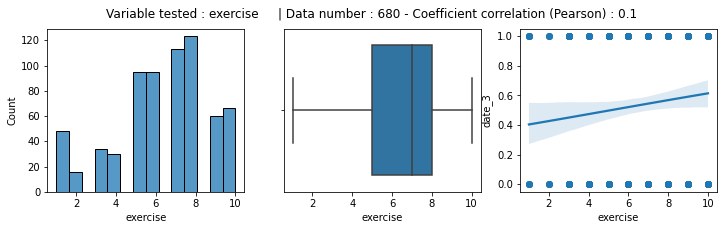

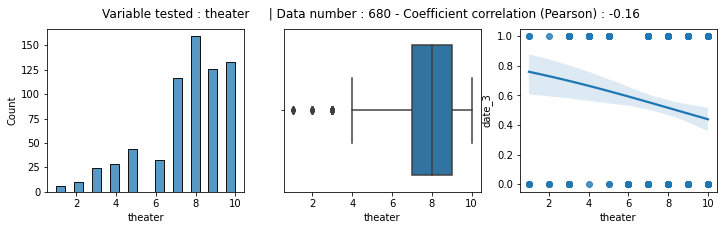

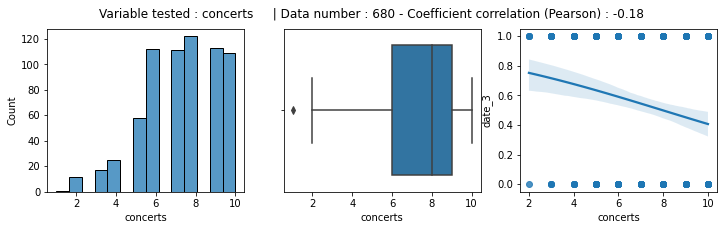

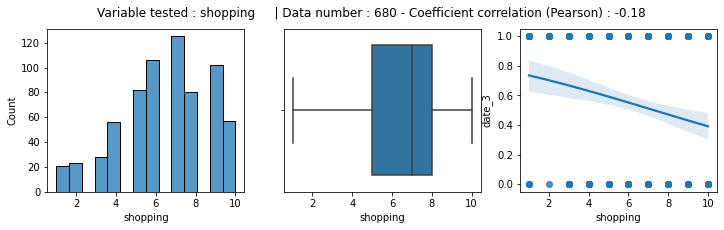

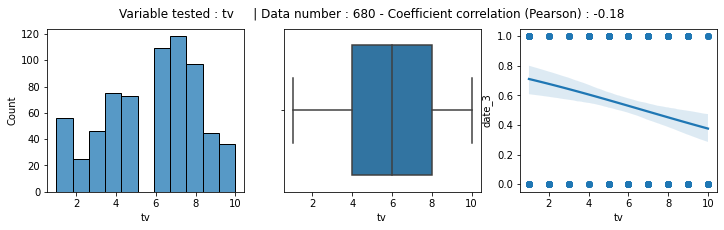

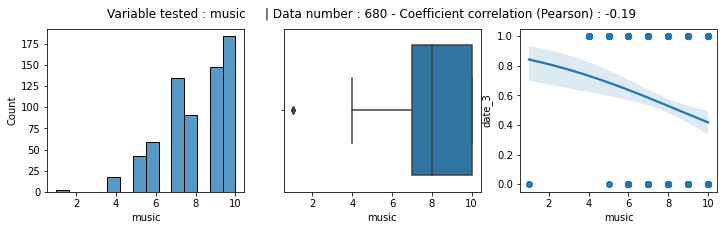

In [48]:
display_distrib_all_corr_top(data_women_with_match_activities,top_dec_women_with_match_activities,'date_3')

Despite the fact that we only have 680 encounter cases for women who have a "match" (number of data in the entire visualization), it would be possible that we have a positive correlation with: hiking, clubbing, maybe yoga... (exercise too low).
And maybe (it is less sure!) a negative correlation with: music, TV, shopping, concerts, theater...
The first activities may be shared with men, in general (hiking first) while the second, perhaps, are activities of individual or specific taste (music, TV) or activities that men do not like much (shopping, theater) in general.

And for men :

In [49]:
data_men_with_match_activities = data_men_with_match.loc[:,[term for term in data_men_with_match if term in activies or term =='date_3']]
not_selectionned = ['date_3']
top_dec_men_with_match_activities = correlation_top(data_men_with_match_activities,'date_3',not_selectionned,0.1)
top_dec_men_with_match_activities

reading     0.140059
museums    -0.103525
tv         -0.120499
dining     -0.136331
movies     -0.168572
clubbing   -0.212482
concerts   -0.249135
gaming     -0.320386
Name: date_3, dtype: float64

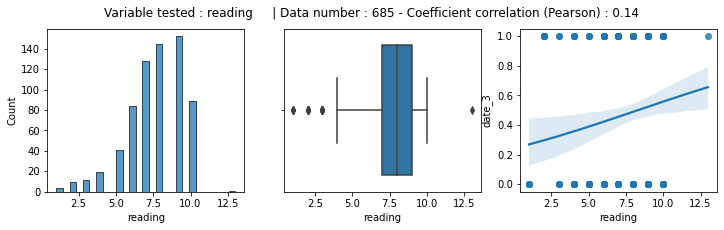

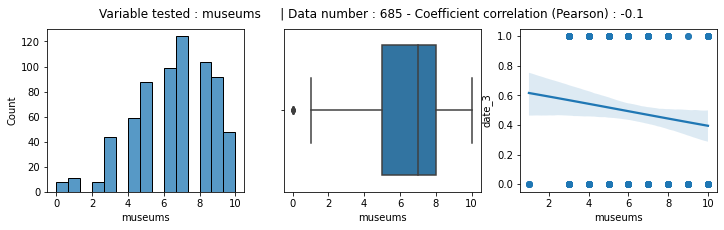

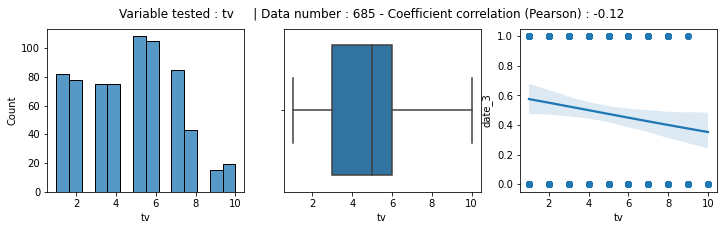

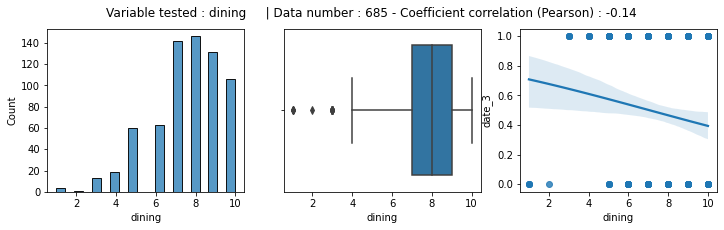

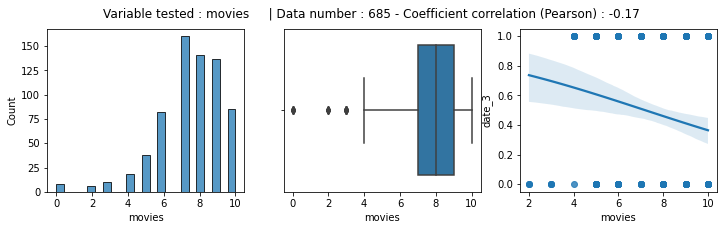

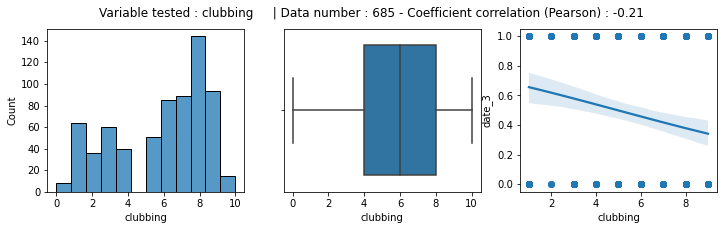

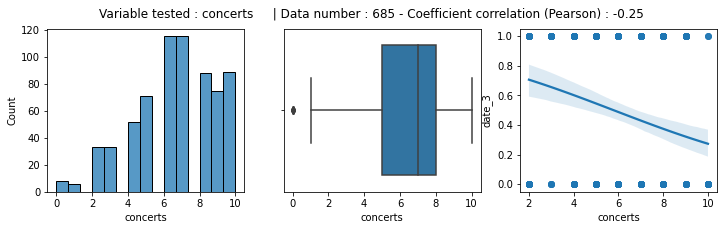

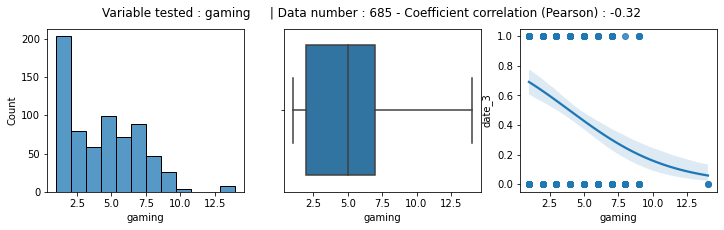

In [50]:
display_distrib_all_corr_top(data_men_with_match_activities,top_dec_men_with_match_activities,'date_3')

For men, we have a lot of negative correlation !
If we don't retain "dining", "theater", "museums" and "tv" (too low coefficients)...
we perhaps can keep "movies", "clubbing", "concerts" and "gaming" ! (for it, the correlation is greater !), very personal, masculine activities (okay, if movies are perhaps "men movies" and concerts are perhaps "men concerts" ?...)

Let's finish hazardous assumptions and let's see visualization with our function rep_by_step :

In [51]:
list_tested=['sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
rep_by_step(list_tested)

Ok, the tree courbes are very stables !...
The only significant difference is for men : in the step 3, they play a litte less at video games... (but it's not a preponderant activity at least) and there is a little difference too with concerts and clubbings...
But all of this it perhaps a variance case : if we read that from right to the left (data : 359 -> data : 1365 -> data : 8299), it seems like a stabilization of the mean of all responses !...

#### 3.2 Impact of "others" variable in a second date

Here, we explore the others variables on the podium...

In [52]:
others = ['met','imprace','age','imprelig']

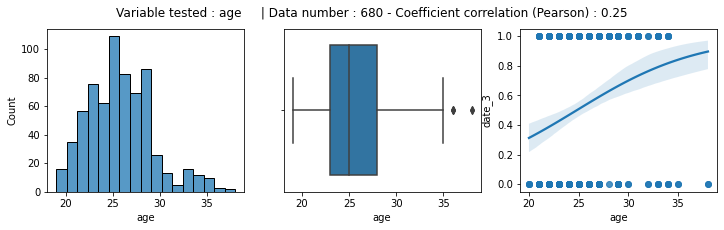

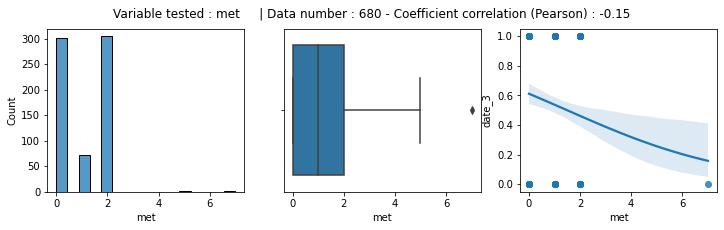

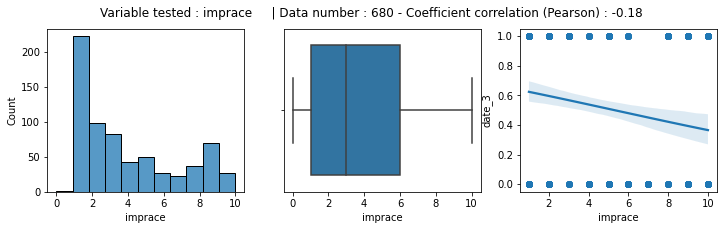

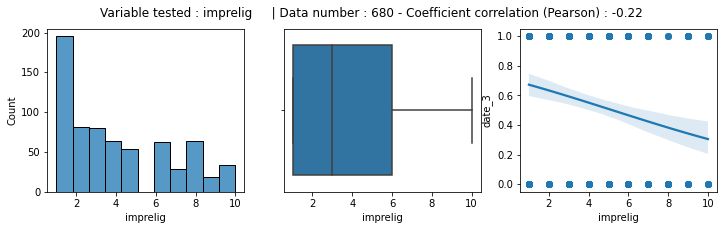

In [53]:
data_women_with_match_others = data_women_with_match.loc[:,[term for term in data_women_with_match if term in others or term =='date_3']]
not_selectionned = ['date_3']
top_dec_women_with_match_others = correlation_top(data_women_with_match_others,'date_3',not_selectionned,0.1)
display_distrib_all_corr_top(data_women_with_match_others,top_dec_women_with_match_others,'date_3')

We can exclude 'met' (very bad distribution !).. So perhaps there are little positive correlations with 'age' for women... and little negative corellations with importance of race and religion... 

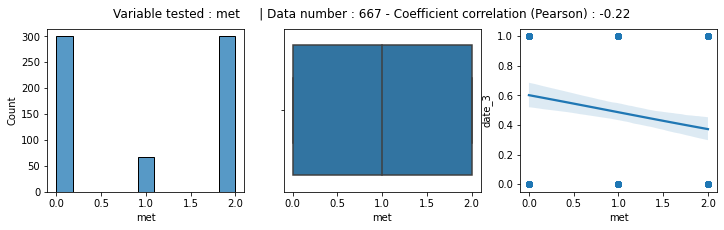

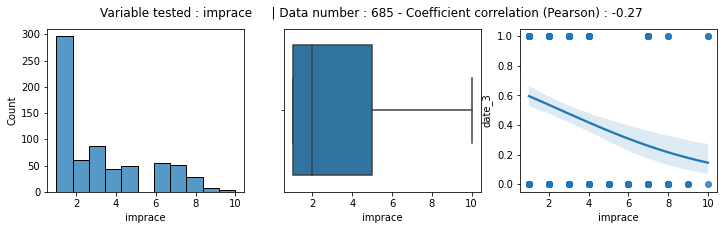

In [54]:
data_men_with_match_others = data_men_with_match.loc[:,[term for term in data_men_with_match if term in others or term =='date_3']]
not_selectionned = ['date_3']
top_dec_men_with_match_others = correlation_top(data_men_with_match_others,'date_3',not_selectionned,0.1)
display_distrib_all_corr_top(data_men_with_match_others,top_dec_men_with_match_others,'date_3')

For men, we just 'importance of race'...

In [68]:
list_tested=['imprace','imprelig','age']
rep_by_step(list_tested)

Deception ! Very stable ! Perhaps 'non-importance of race' have a little impact on the second date ?...

#### 3.3 Impact of the suvey's answers variable in a second date

First, we have to limited the study... A lot of questions have been built with a bad proptocol... (or different protocols...) And the notice is wrong for some questions... (It's written there is an other protocol just for waves 5-9, but it's true just for questions 4_1, 4_1, 4_3... and 2_3 ! You can open it on Excel again). The intermediate survey is very bad and we have poor data... So, we exclude all the questions of the intermediate sruvey ('..._s') and questions 4-1, 4-1, 4-3, 2-3 :

In [69]:
bad_survey=['attr1_s','sinc1_s','intel1_s','fun1_s','amb1_s','shar1_s','attr3_s','sinc3_s','intel3_s','fun3_s','amb3_s','attr4_1','sinc4_1','intel4_1','fun4_1','amb4_1','shar4_1','attr4_2','sinc4_2','intel4_2','fun4_2','amb4_2','shar4_2','attr4_3','sinc4_3','intel4_3','fun4_3','amb4_3','shar4_3','attr2_3','sinc2_3','intel2_3','fun2_3','amb2_3','shar2_3']

Also, in the construction of our 'podium', we can exclude the doublon 'amb5_1' because whe have 'amb5_2'... 

In [73]:
data_women_with_match_clean_survey = data_women_with_match.loc[:,[term for term in data_women_with_match if term not in bad_survey and term not in activies and term not in others]]
not_selectionned = ['date_3','them_cal','pid','iid','wave','amb5_1']
top_dec_women_with_match_survey = correlation_top(data_women_with_match_clean_survey,'date_3',not_selectionned,0.20)
top_dec_women_with_match_survey

shar1_3     0.255144
intel2_2    0.204942
satis_2     0.203723
sinc5_1    -0.212878
fun3_3     -0.231962
fun5_2     -0.268032
intel5_2   -0.302085
amb5_2     -0.388358
Name: date_3, dtype: float64

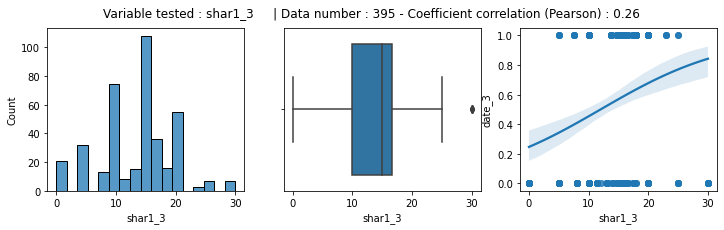

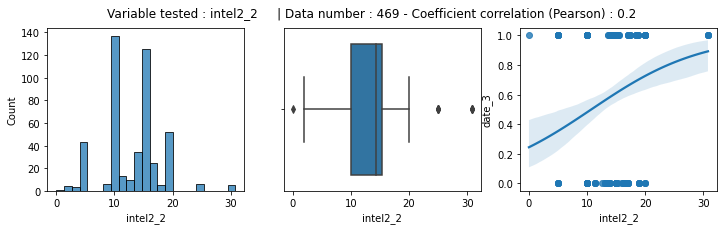

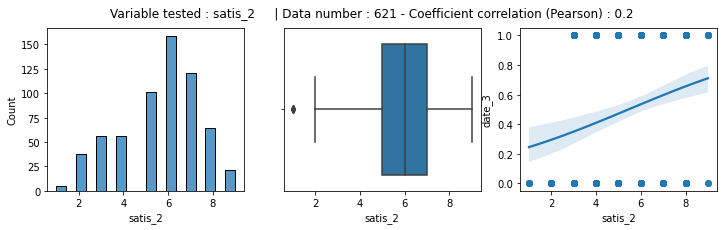

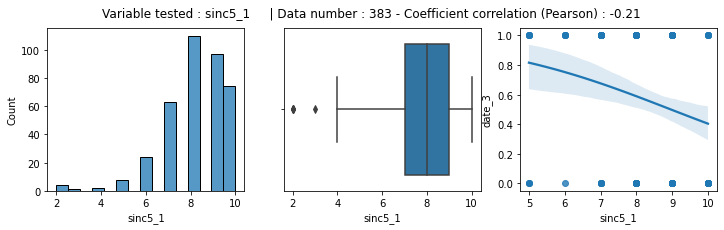

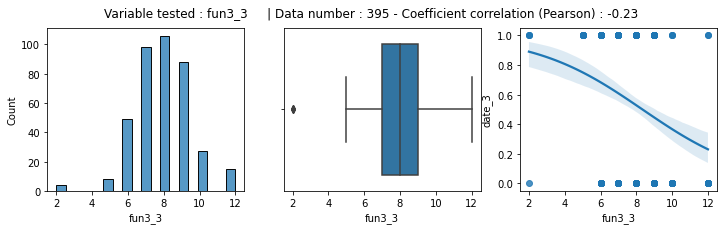

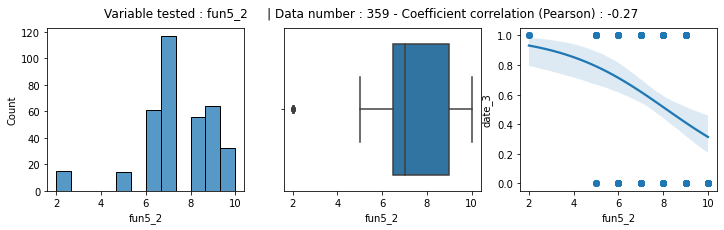

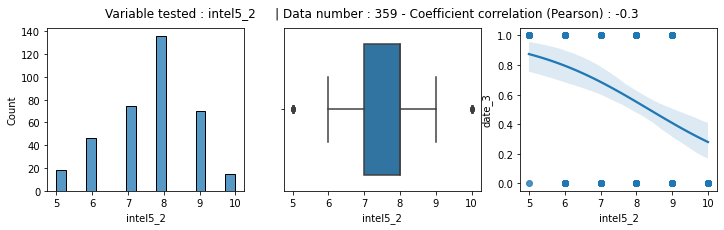

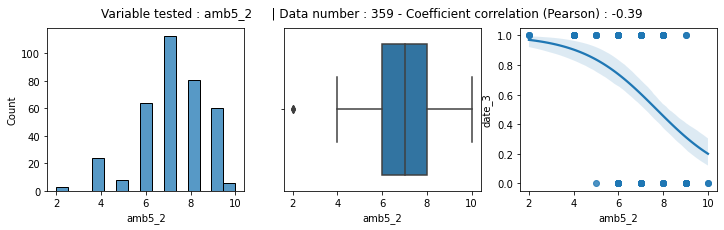

In [74]:
display_distrib_all_corr_top(data_women_with_match_clean_survey,top_dec_women_with_match_survey,'date_3')

For women,

perhaps we can retain all these parameters except 'fun3_3' (there is a problem with a value '12' in the range (?!... ) , 'sinc5_1', 'intel2_2'...
So, it's possible these factors play with the construction of a second date :
- In the last survey, To think we have hobbies/interests with others persons of opposite sexe (it's logical)
- To be satisfied of the speed dating (it's logical too, it's a like a 'mechanical' consequence...)
- In the second survey, not to think men are trying to find fun women
- In the second survey, not to think men are trying to find intelligent women
- In the second survey, not to think men are trying to find ambitious women

In [77]:
data_men_with_match_clean_survey = data_men_with_match.loc[:,[term for term in data_men_with_match if term not in bad_survey and term not in activies and term not in others]]
not_selectionned = ['match_es','date_3','them_cal','you_call','condtn','career_c','field_cd','shar2_2','shar1_1']
top_dec_men_with_match_survey = correlation_top(data_men_with_match_clean_survey,'date_3',not_selectionned,0.2)
top_dec_men_with_match_survey

amb2_1     0.351253
sinc5_2    0.252278
amb1_3    -0.213231
shar1_2   -0.239083
shar2_1   -0.320624
Name: date_3, dtype: float64

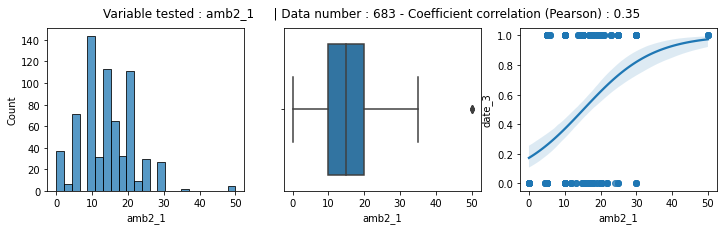

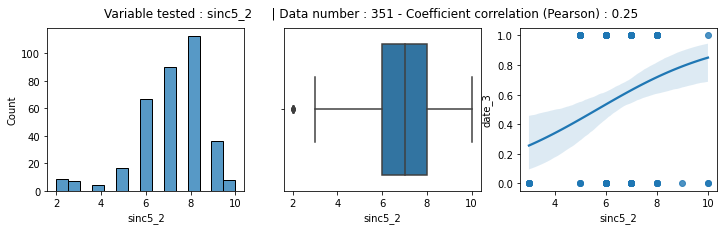

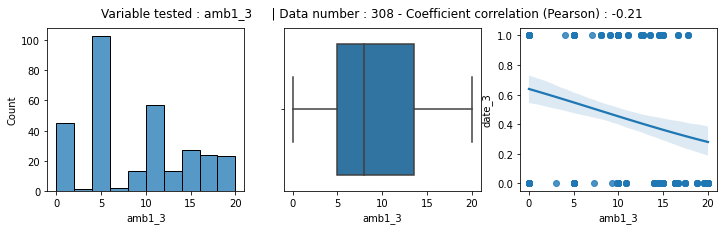

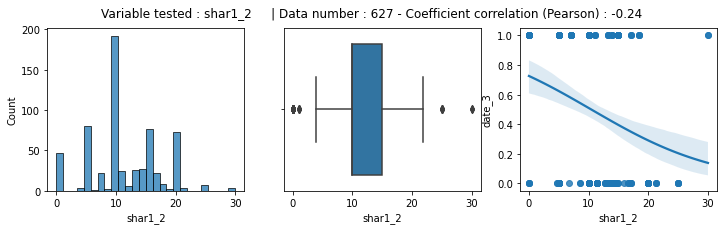

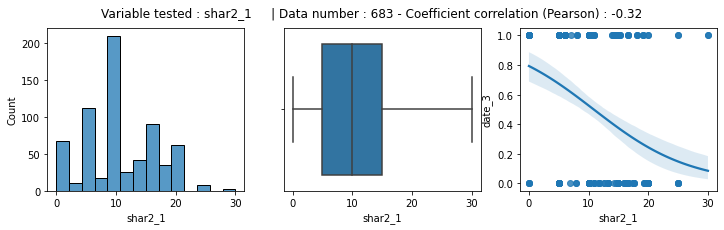

In [78]:
display_distrib_all_corr_top(data_men_with_match_clean_survey,top_dec_men_with_match_survey,'date_3')

For men,

It's possible these factors play with the construction of a second date :
- In the first survey, to think women are trying to find ambitious men
- BUT in the third survey, not to think ' Ok, I'm an ambitous man... '
- In the second survey, to think people are thinking 'I'm a sincere person'
- In the third survey, not to think people in general are trying to find some hobbies/interest to be shared
- In the first survey, not to think women are trying to find hobbies/interest to be shared


Ok, why not ?... Let's see the 'big' visualisation of all of these with our second pratic tool... Just for the principals survey's questions (deduced by the lasts results 'podium') :

In [79]:
charac_list=['attr','sinc','intel','fun','amb','shar']
combi_list=[(1,2),(1,3),(2,1),(2,2),(3,3),(5,1),(5,2)]
charac_list_for_3_and_5=['attr','sinc','intel','fun','amb']
for i,j in combi_list:
    if i == 3 or i == 5 :
        list_tested=['{}{}_{}'.format(term,i,j) for term in charac_list_for_3_and_5]
    else:
        list_tested=['{}{}_{}'.format(term,i,j) for term in charac_list]
    rep_by_step(list_tested)

Ok, let's get back to earth!... The variations are actually very, very little...
And perhaps reduction of the universe at the different steps (number of data) is just an expression of the variance...


### Conclusion

In the last part, it was very difficult to do something with the survey responses... We had very big problems with protocols, normalizations, missing values... Nevertheless, we tried to do something, and we didn't find good solutions either... just small 'impressions' of small possible correlations. Also, because responses seem very stable (think of our initial heatmap: attr1_1 is correlated to attr1_2, attr1_3...), it will be difficult to understand the evolution of the responses as well (it's an other tentative we had make but we cut this study and results were very bad...)... Maybe Machine Learning could help us on this topic if we want to continue studying these responses.

On the other hand, we managed to find out what kind of parameter the family mainly plays in the first stage of the experiment (during the speed dating evening):
- The characteristics of the opposite sex (Attractiveness, Sincerity... etc...)


And we managed to order this: Attraction, fun, shared hobbies/interests seem to be more important than intelligence, sincerity and ambition for both sexes.
In four minutes, is it really possible to judge intelligence, sincerity ... ? What jumps out at us in four minutes ? If the person is pleasant to look at, if he or she is funny... And what are probably the best topics of conversation when you don't have time ? Maybe: "Please, tell me quickly, what are your hobbies, interests...?'

In the second stage of the experiment (after speed dating), we saw that other parameters, different from the first ones, seem to play mainly... and that the family of the first parameter (the evaluation of characteristics) plays much less in the final result. It disappears completely in our 'podium' models) in favor of the parameter families of the other :
- Favorite activities... perhaps because it is the embodiment of the answer to the question 'Ok, now, really, do we have common hobbies/interests ?
- Maybe the importance of religion, race, maybe age... but it's not very blatant...
- And the survey answers... it's not very conclusive but it seems like it just says: 'Ok, the problem of knowing what plays into the construction of a second date is very complex and most of the psychological factors are there, much more than in the first stage of speed dating...'

The next step would be to confront this with Machine Learning and check if we find these factors in step 1 and in step 2... but our EDA stops here...